
# PyTorch MLP classification

This notebook loads the MNIST Fashion dataset for classification<br>  Then trains a small MLP classifier on it.


## 1) Setup

In [1]:

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import torchvision
from torchvision import transforms

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

## 2) Load dataset

In [2]:
# Define a transformation to convert images to PyTorch tensors (else they come back as PIL images)
transform = transforms.ToTensor()

try:
    train_set = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    test_set  = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)
except Exception as e:
    print("MNIST download failed", e)
 

### Look at the first image and its label

(-0.5, 27.5, 27.5, -0.5)

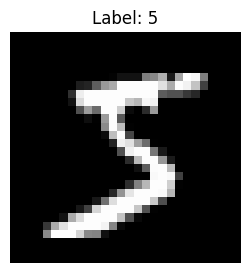

In [3]:
# dir(train_set)
# train_set.transforms  #the mean and the standard deviation used for normalization
import matplotlib.pyplot as plt

img, label = train_set[0]

plt.figure(figsize=(3,3))
plt.imshow(img.squeeze().to("cpu").numpy(), cmap="gray")
plt.title(f"Label: {label}")
plt.axis("off")


### Is it balanced? (eyeball audit here)

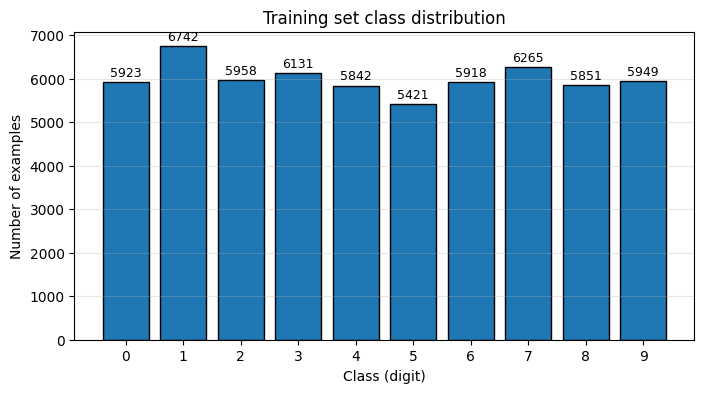

In [4]:
# Histogram / class distribution for the training set (MNIST digits 0-9)
try:
    counts_tensor = counts
except NameError:
    if hasattr(train_set, "targets"):
        counts_tensor = torch.bincount(train_set.targets)
    elif 'labels' in globals():
        counts_tensor = torch.bincount(labels)
    else:
        raise RuntimeError("No label/counts found in notebook namespace.")

counts_np = counts_tensor.to("cpu").numpy()
classes = list(range(len(counts_np)))

plt.figure(figsize=(8,4))
plt.bar(classes, counts_np, color="C0", edgecolor="k")
plt.xticks(classes)
plt.xlabel("Class (digit)")
plt.ylabel("Number of examples")
plt.title("Training set class distribution")
for x, y in zip(classes, counts_np):
    plt.text(x, y + max(counts_np) * 0.01, str(y), ha="center", va="bottom", fontsize=9)
plt.grid(axis="y", alpha=0.3)
plt.show()

## 3) Feature scaling (normalization)

Note that there are no for loops, vectorized operations only

### Is it normalized?

In [5]:
from torch.utils.data import DataLoader

# Compute per-channel mean and std for train_set (assumes train_set.transform returns tensors in [0,1], e.g. ToTensor)

loader = DataLoader(train_set, batch_size=1024, shuffle=False, num_workers=2, pin_memory=True)

sum_mean = torch.zeros(1)
sum_sq_mean = torch.zeros(1)
n = 0

with torch.no_grad():
    for xb, _ in loader:
        # xb shape: (B, C, H, W)
        b = xb.size(0)
        xb_flat = xb.view(b, xb.size(1), -1)            # (B, C, H*W)
        sum_mean += xb_flat.mean(dim=2).sum(dim=0)      # sum of per-sample means (per channel)
        sum_sq_mean += (xb_flat ** 2).mean(dim=2).sum(dim=0)
        n += b

mean = (sum_mean / n).cpu()
std = torch.sqrt((sum_sq_mean / n) - mean**2).cpu()

print("mean =", mean.tolist())
print("std  =", std.tolist())

mean = [0.1306605190038681]
std  = [0.30810779333114624]


### No its not otherwise the mean would be 0 and the std would be 1<br><br>
### So normalize it

In [6]:
# attach a Normalize transform using the computed mean/std (mean/std are torch tensors)
norm_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(tuple(mean), tuple(std))
])

train_set.transform = norm_transform
test_set.transform = norm_transform

print("Transforms updated for train_set and test_set:")
print(" train_set.transform =", train_set.transform)
# quick sanity check on first sample
x, y = train_set[0]
print("sample mean/std (after transform) =", float(x.mean()), float(x.std()))

Transforms updated for train_set and test_set:
 train_set.transform = Compose(
    ToTensor()
    Normalize(mean=(tensor(0.1307),), std=(tensor(0.3081),))
)
sample mean/std (after transform) = 0.022782763466238976 1.014410376548767


### HELPFUL BIT: Its a good idea to take a fraction of data to test your code.<br> This way you dont have to wait a long time for each run

In [7]:
SMALL_SET=False  # set to True to use a smaller dataset for quicker testing
if SMALL_SET:
    train_set = torch.utils.data.Subset(train_set, list(range(1000)))
    test_set = torch.utils.data.Subset(test_set, list(range(1000)))

### Wrap the datasets with DataLoaders

In [8]:
# Wrap datasets in DataLoaders for training/evaluation
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = DataLoader(test_set,  batch_size=256, shuffle=False)

print("train_loader batches:", len(train_loader), "val_loader batches:", len(val_loader))
# sanity check a sample batch
xb_sample, y_sample = next(iter(train_loader))
print("xb_sample shape:", xb_sample.shape, "y_sample shape:", y_sample.shape)

train_loader batches: 469 val_loader batches: 40
xb_sample shape: torch.Size([128, 1, 28, 28]) y_sample shape: torch.Size([128])


## 4) Define the MLP model

torch.nn has the classes necessary for building Neural Networks 

In [9]:
class MLP(nn.Module):   #notice that we inherit from nn.Module
    def __init__(self, in_dim=784, hid=256, out_dim=10):    #28x28 image=784
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hid), 
            nn.ReLU(),
            nn.Linear(hid, out_dim)
        )
    def forward(self, x):
        return self.net(x)

model = MLP().to(device)    #put on device of choice (GPU or CPU)

print("Total trainable model params=", sum(p.numel() for p in model.parameters())/1e6, "Million")  # 1st layer=(784*256 + 256 biases), 2nd layer=256*10 + 10 biases = 0.2M


Total trainable model params= 0.20353 Million



**Notes**
- For classification with integer labels, use `nn.CrossEntropyLoss` with **logits** (no softmax).
- For regression, `nn.MSELoss` and ensure shapes align (`[N, 1]` vs `[N]`).
- Common optimizers: `SGD` and `Adam`.


## 5) Train and evaluate functions


In [10]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

@torch.no_grad()  # Disable gradient tracking inside this function (saves memory/compute)
def evaluate(model, loader, criterion, device):
    """
    Puts the model in evaluation mode and computes the average loss
    over all batches in `loader`.

    Args:
        model:     a torch.nn.Module
        loader:    DataLoader for validation/test data
        criterion: loss function (e.g., nn.MSELoss())
        device:    'cuda' or 'cpu' device to run on

    Returns:
        avg_loss (float): mean loss over the dataset
    """
    model.eval()          # turn off dropout / use running stats for batchnorm, etc.
    total_loss,correct, total_n = 0.0, 0, 0

    for xb, yb in loader:
        # Move the current batch to the right device
        xb, yb = xb.to(device), yb.to(device)
        if xb.dim() > 2: xb = xb.view(xb.size(0), -1)

        # Forward pass only (no grad because of @torch.no_grad)
        preds = model(xb)
        loss = criterion(preds, yb)

        # Accumulate *sum* of losses so we can compute dataset average
        total_loss += loss.item() * xb.size(0)  # multiply by batch size
        pred = preds.argmax(dim=1)
        correct += (pred == yb).sum().item()
        total_n    += xb.size(0)

    return total_loss / total_n, correct / total_n  # average loss over all examples


def train(model, train_loader, val_loader, criterion, optimizer, device, epochs=200, log_every=20):
    """
    Standard training loop with per-epoch validation.

    Args:
        model:        a torch.nn.Module
        train_loader: DataLoader for training data
        val_loader:   DataLoader for validation data
        criterion:    loss function (e.g., nn.MSELoss())
        optimizer:    torch.optim optimizer (e.g., Adam)
        device:       'cuda' or 'cpu'
        epochs:       number of training epochs
        log_every:    how often to print progress (in epochs)
    """
    for epoch in range(1, epochs + 1):
        model.train()                # enable training behavior (dropout, batchnorm updates, etc.)
        running_loss,correct, total_n = 0.0, 0, 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            
            # print(xb.shape )
            # Example: flatten if using MLP on images
            if xb.dim() > 2: xb = xb.view(xb.size(0), -1)
            # print(xb.shape )
            # break
            
            # 1) Reset gradients from the previous step
            optimizer.zero_grad()
            #    set_to_none=True can be a tiny memory/perf win vs. zeroing to 0.0

            # 2) Forward pass: compute predictions and loss
            preds = model(xb)
            loss  = criterion(preds, yb)  # e.g., MSE loss

            # 3) Backward pass: compute gradients w.r.t. parameters
            loss.backward()

            # 4) Update parameters using the optimizer, this will subtract a small bit (lr*grad) of the gradient from each parameter
            optimizer.step()

            # Track running training loss (sum over all samples)
            # running_loss += loss.item() * xb.size(0)  #MSELoss
            running_loss += loss.item() * xb.size(0)

            #how many correct in this batch
            pred = preds.argmax(dim=1)
            correct += (pred == yb).sum().item()

            total_n += xb.size(0)

        # Average train loss this epoch
        train_mse = running_loss / total_n

        # Average train accuracy this epoch
        train_acc = correct / total_n

        # Evaluate on the validation set (no-grad inside)
        val_mse, val_acc = evaluate(model, val_loader, criterion, device)

        # Print progress
        if (epoch % log_every == 0) or (epoch == 1):
            print(f"epoch {epoch:03d} | train loss {train_mse:.4f} | train Acc {train_acc:.4f} | val loss {val_mse:.4f} | val Acc {val_acc:.4f}")


## 6) Loss & optimizer

torch.nn also has the loss functions and optimizers for training

In [11]:
lr=1e-2
criterion = nn.CrossEntropyLoss()   
optimizer = torch.optim.Adam(model.parameters(), lr=lr)    


## 7) Train Model

In [12]:
train(model, train_loader, val_loader, criterion, optimizer, device, epochs=10, log_every=2)


epoch 001 | train loss 0.2546 | train Acc 0.9244 | val loss 0.1617 | val Acc 0.9530
epoch 002 | train loss 0.1545 | train Acc 0.9554 | val loss 0.1686 | val Acc 0.9577
epoch 004 | train loss 0.1337 | train Acc 0.9637 | val loss 0.1662 | val Acc 0.9583
epoch 006 | train loss 0.1314 | train Acc 0.9671 | val loss 0.2044 | val Acc 0.9577
epoch 008 | train loss 0.1110 | train Acc 0.9718 | val loss 0.2217 | val Acc 0.9577
epoch 010 | train loss 0.1090 | train Acc 0.9733 | val loss 0.2082 | val Acc 0.9636


### Checkpointing (save & load)

In [13]:

# Save
torch.save({
    "model": model.state_dict(),
    "opt": optimizer.state_dict()
}, "ckpt_demo.pt")
print("Saved to ckpt_demo.pt")

# Load
ckpt = torch.load("ckpt_demo.pt", map_location=device)
model.load_state_dict(ckpt["model"])
optimizer.load_state_dict(ckpt["opt"])
print("Reloaded checkpoint.")


Saved to ckpt_demo.pt
Reloaded checkpoint.



**Tips**
- Increase `DataLoader(num_workers, pin_memory=True)` for faster host→device transfer.



## Gotchas, Debugging, Next Steps



In [14]:

# Common checks
try:
    print("xb dtype/device:", xb.dtype, xb.device)
except NameError:
    print("Run the DataLoader cell first to define a sample batch (xb).")

print("First parameter device:", next(model.parameters()).device)

# NaN/Inf scan (example) are any of the parameters NaN/Inf?
# These are useless for the NN

bad = []
for name, p in model.named_parameters():
    if torch.isnan(p).any() or torch.isinf(p).any():
        bad.append(name)
print("Params with NaN/Inf:", bad or "None")


xb dtype/device: torch.float32 cpu
First parameter device: cpu
Params with NaN/Inf: None
